# UFC Fight Prediction


In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [4]:
# Read in the CSV file (data.csv) as a DataFrame
ufc_df = pd.read_csv("Resources/scraped_data.csv")
ufc_df


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,98,122,139,142,146,163,166,259,300,303,307,324,327) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198,1994-12-16,UFC 4 Tournament Title,No Time Limit,1,Red,SUB,Dan Severn,36,74,250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6199,1994-12-16,Open Weight,No Time Limit,1,Red,SUB,Ron van Clief,51,70,190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6200,1994-09-09,Open Weight,No Time Limit,1,Red,SUB,Kimo Leopoldo,26,75,235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6201,1994-03-11,UFC 2 Tournament Title,No Time Limit,1,Red,KO/TKO,Patrick Smith,30,74,225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning


In [5]:
# Dropping duplicate rows. Can happen sometimes due to the new even being scraped.
ufc_df = ufc_df.drop_duplicates(["Event_Date", "B_Name", "R_Name"])

In [6]:
# Converting Event_Date column values to datetime64 to drop older fights below
ufc_df["Event_Date"] = pd.to_datetime(ufc_df["Event_Date"])

In [7]:
# Removing old fights due to the lack of rule consistency
ufc_df = ufc_df[ufc_df["Event_Date"] >= pd.to_datetime("5/3/2001")]

In [8]:
# TODO: Look into what the mixed datatypes are in each column (from the warning message after reading the csv).
# DtypeWarning: Columns (2,97,121,138,141,145,162,165,257,298,301,305,322,325) have mixed types.
# ufc_df.iloc[:,2].unique()
ufc_df.dtypes.value_counts()


float64           177
int64             103
object             47
datetime64[ns]      1
dtype: int64

In [9]:
# TODO: Fix handling of `--`, `---`, or `No Time Limit`; I was unsure on what each value means so I just set them to NaN.
ufc_df = ufc_df.replace("--", np.NaN)
ufc_df = ufc_df.replace("---", np.NaN)
ufc_df = ufc_df.replace("No Time Limit", np.NaN)


In [10]:
#Splitting in order to get the No contest value
B_Draws_Split = ufc_df["B_Draws"].str.split("(", n=1, expand = True)
ufc_df["B_No_Contest"] = B_Draws_Split[1]

# Keeping only the draws in the column
ufc_df["B_Draws"] = B_Draws_Split[0]

In [11]:
# Stripping the NC and filling "None" with NaN
ufc_df["B_No_Contest"] = ufc_df["B_No_Contest"].str.strip("NC)")
ufc_df["B_No_Contest"].fillna(np.nan, inplace=True)
ufc_df["B_No_Contest"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
6095    NaN
6096    NaN
6097    NaN
6098    NaN
6099     1 
Name: B_No_Contest, Length: 6100, dtype: object

In [12]:
#Splitting in order to get the No contest value
R_Draws_Split = ufc_df["R_Draws"].str.split("(", n=1, expand = True)
ufc_df["R_No_Contest"] = R_Draws_Split[1]

# Keeping only the draws in the column
ufc_df["R_Draws"] = R_Draws_Split[0]

In [13]:
# Stripping the NC and filling "None" with NaN
ufc_df["R_No_Contest"] = ufc_df["R_No_Contest"].str.strip("NC)")
ufc_df["R_No_Contest"].fillna(np.nan, inplace=True)
ufc_df["R_No_Contest"]



0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
6095     1 
6096    NaN
6097    NaN
6098    NaN
6099    NaN
Name: R_No_Contest, Length: 6100, dtype: object

In [14]:
#NEW COLUMN ORDER
new_column_order = ['Event_Date',
                    'Weight_Class',
                    'Max_Rounds',
                    'Ending_Round',
                    'Winner',
                    'Win_By',
                    'B_Name',
                    'B_Age',
                    'B_Height',
                    'B_Weight',
                    'B_Reach',
                    'B_Stance',
                    'B_Wins',
                    'B_Losses',
                    'B_Draws',
                    'B_No_Contest',
                    'B_Career_Significant_Strikes_Landed_PM',
                    'B_Career_Striking_Accuracy',
                    'B_Career_Significant_Strike_Defence',
                    'B_Career_Takedown_Average',
                    'B_Career_Takedown_Accuracy',
                    'B_Career_Takedown_Defence',
                    'B_Career_Submission_Average',
                    'B_Knockdowns',
                    'B_Significant_Strikes_Landed',
                    'B_Significant_Strikes_Attempted',
                    'B_Significant_Strike_Perc',
                    'B_Significant_Strikes_Distance_Landed',
                    'B_Significant_Strikes_Distance_Attempted',
                    'B_Significant_Strikes_Clinch_Landed',
                    'B_Significant_Strikes_Clinch_Attempted',
                    'B_Significant_Strikes_Ground_Landed',
                    'B_Significant_Strikes_Ground_Attempted',
                    'B_Head_Significant_Strikes_Attempted',
                    'B_Head_Significant_Strikes_Landed',
                    'B_Body_Significant_Strikes_Attempted',
                    'B_Body_Significant_Strikes_Landed',
                    'B_Leg_Significant_Strikes_Attempted',
                    'B_Leg_Significant_Strikes_Landed',
                    'B_Total_Strikes_Attempted',
                    'B_Total_Strikes_Landed',
                    'B_Takedowns_Attempted',
                    'B_Takedowns_Landed',
                    'B_Takedown_Perc',
                    'B_Submission_Attempts',
                    'B_Grappling_Reversals',
                    'B_Grappling_Control_Time',
                    'B_Round_One_Knockdowns',
                    'B_Round_One_Significant_Strikes_Landed',
                    'B_Round_One_Significant_Strikes_Attempted',
                    'B_Round_One_Significant_Strike_Perc',
                    'B_Round_One_Significant_Strikes_Distance_Landed',
                    'B_Round_One_Significant_Strikes_Distance_Attempted',
                    'B_Round_One_Significant_Strikes_Clinch_Landed',
                    'B_Round_One_Significant_Strikes_Clinch_Attempted',
                    'B_Round_One_Significant_Strikes_Ground_Landed',
                    'B_Round_One_Significant_Strikes_Ground_Attempted',
                    'B_Round_One_Head_Significant_Strikes_Attempted',
                    'B_Round_One_Head_Significant_Strikes_Landed',
                    'B_Round_One_Body_Significant_Strikes_Attempted',
                    'B_Round_One_Body_Significant_Strikes_Landed',
                    'B_Round_One_Leg_Significant_Strikes_Attempted',
                    'B_Round_One_Leg_Significant_Strikes_Landed',
                    'B_Round_One_Total_Strikes_Attempted',
                    'B_Round_One_Total_Strikes_Landed',
                    'B_Round_One_Takedowns_Attempted',
                    'B_Round_One_Takedowns_Landed',
                    'B_Round_One_Takedown_Perc',
                    'B_Round_One_Submission_Attempts',
                    'B_Round_One_Grappling_Reversals',
                    'B_Round_One_Grappling_Control_Time',
                    'B_Round_Two_Knockdowns',
                    'B_Round_Two_Significant_Strikes_Landed',
                    'B_Round_Two_Significant_Strikes_Attempted',
                    'B_Round_Two_Significant_Strike_Perc',
                    'B_Round_Two_Significant_Strikes_Distance_Landed',
                    'B_Round_Two_Significant_Strikes_Distance_Attempted',
                    'B_Round_Two_Significant_Strikes_Clinch_Landed',
                    'B_Round_Two_Significant_Strikes_Clinch_Attempted',
                    'B_Round_Two_Significant_Strikes_Ground_Landed',
                    'B_Round_Two_Significant_Strikes_Ground_Attempted',
                    'B_Round_Two_Head_Significant_Strikes_Attempted',
                    'B_Round_Two_Head_Significant_Strikes_Landed',
                    'B_Round_Two_Body_Significant_Strikes_Attempted',
                    'B_Round_Two_Body_Significant_Strikes_Landed',
                    'B_Round_Two_Leg_Significant_Strikes_Attempted',
                    'B_Round_Two_Leg_Significant_Strikes_Landed',
                    'B_Round_Two_Total_Strikes_Attempted',
                    'B_Round_Two_Total_Strikes_Landed',
                    'B_Round_Two_Takedowns_Attempted',
                    'B_Round_Two_Takedowns_Landed',
                    'B_Round_Two_Takedown_Perc',
                    'B_Round_Two_Submission_Attempts',
                    'B_Round_Two_Grappling_Reversals',
                    'B_Round_Two_Grappling_Control_Time',
                    'B_Round_Three_Knockdowns',
                    'B_Round_Three_Significant_Strikes_Landed',
                    'B_Round_Three_Significant_Strikes_Attempted',
                    'B_Round_Three_Significant_Strike_Perc',
                    'B_Round_Three_Significant_Strikes_Distance_Landed',
                    'B_Round_Three_Significant_Strikes_Distance_Attempted',
                    'B_Round_Three_Significant_Strikes_Clinch_Landed',
                    'B_Round_Three_Significant_Strikes_Clinch_Attempted',
                    'B_Round_Three_Significant_Strikes_Ground_Landed',
                    'B_Round_Three_Significant_Strikes_Ground_Attempted',
                    'B_Round_Three_Head_Significant_Strikes_Attempted',
                    'B_Round_Three_Head_Significant_Strikes_Landed',
                    'B_Round_Three_Body_Significant_Strikes_Attempted',
                    'B_Round_Three_Body_Significant_Strikes_Landed',
                    'B_Round_Three_Leg_Significant_Strikes_Attempted',
                    'B_Round_Three_Leg_Significant_Strikes_Landed',
                    'B_Round_Three_Total_Strikes_Attempted',
                    'B_Round_Three_Total_Strikes_Landed',
                    'B_Round_Three_Takedowns_Attempted',
                    'B_Round_Three_Takedowns_Landed',
                    'B_Round_Three_Takedown_Perc',
                    'B_Round_Three_Submission_Attempts',
                    'B_Round_Three_Grappling_Reversals',
                    'B_Round_Three_Grappling_Control_Time',
                    'B_Round_Four_Knockdowns',
                    'B_Round_Four_Significant_Strikes_Landed',
                    'B_Round_Four_Significant_Strikes_Attempted',
                    'B_Round_Four_Significant_Strike_Perc',
                    'B_Round_Four_Significant_Strikes_Distance_Landed',
                    'B_Round_Four_Significant_Strikes_Distance_Attempted',
                    'B_Round_Four_Significant_Strikes_Clinch_Landed',
                    'B_Round_Four_Significant_Strikes_Clinch_Attempted',
                    'B_Round_Four_Significant_Strikes_Ground_Landed',
                    'B_Round_Four_Significant_Strikes_Ground_Attempted',
                    'B_Round_Four_Head_Significant_Strikes_Attempted',
                    'B_Round_Four_Head_Significant_Strikes_Landed',
                    'B_Round_Four_Body_Significant_Strikes_Attempted',
                    'B_Round_Four_Body_Significant_Strikes_Landed',
                    'B_Round_Four_Leg_Significant_Strikes_Attempted',
                    'B_Round_Four_Leg_Significant_Strikes_Landed',
                    'B_Round_Four_Total_Strikes_Attempted',
                    'B_Round_Four_Total_Strikes_Landed',
                    'B_Round_Four_Takedowns_Attempted',
                    'B_Round_Four_Takedowns_Landed',
                    'B_Round_Four_Takedown_Perc',
                    'B_Round_Four_Submission_Attempts',
                    'B_Round_Four_Grappling_Reversals',
                    'B_Round_Four_Grappling_Control_Time',
                    'B_Round_Five_Knockdowns',
                    'B_Round_Five_Significant_Strikes_Landed',
                    'B_Round_Five_Significant_Strikes_Attempted',
                    'B_Round_Five_Significant_Strike_Perc',
                    'B_Round_Five_Significant_Strikes_Distance_Landed',
                    'B_Round_Five_Significant_Strikes_Distance_Attempted',
                    'B_Round_Five_Significant_Strikes_Clinch_Landed',
                    'B_Round_Five_Significant_Strikes_Clinch_Attempted',
                    'B_Round_Five_Significant_Strikes_Ground_Landed',
                    'B_Round_Five_Significant_Strikes_Ground_Attempted',
                    'B_Round_Five_Head_Significant_Strikes_Attempted',
                    'B_Round_Five_Head_Significant_Strikes_Landed',
                    'B_Round_Five_Body_Significant_Strikes_Attempted',
                    'B_Round_Five_Body_Significant_Strikes_Landed',
                    'B_Round_Five_Leg_Significant_Strikes_Attempted',
                    'B_Round_Five_Leg_Significant_Strikes_Landed',
                    'B_Round_Five_Total_Strikes_Attempted',
                    'B_Round_Five_Total_Strikes_Landed',
                    'B_Round_Five_Takedowns_Attempted',
                    'B_Round_Five_Takedowns_Landed',
                    'B_Round_Five_Takedown_Perc',
                    'B_Round_Five_Submission_Attempts',
                    'B_Round_Five_Grappling_Reversals',
                    'B_Round_Five_Grappling_Control_Time',
                    'R_Name',
                    'R_Age',
                    'R_Height',
                    'R_Weight',
                    'R_Reach',
                    'R_Stance',
                    'R_Wins',
                    'R_Losses',
                    'R_Draws',
                    'R_No_Contest',
                    'R_Career_Significant_Strikes_Landed_PM',
                    'R_Career_Striking_Accuracy',
                    'R_Career_Significant_Strike_Defence',
                    'R_Career_Takedown_Average',
                    'R_Career_Takedown_Accuracy',
                    'R_Career_Takedown_Defence',
                    'R_Career_Submission_Average',
                    'R_Knockdowns',
                    'R_Significant_Strikes_Landed',
                    'R_Significant_Strikes_Attempted',
                    'R_Significant_Strike_Perc',
                    'R_Significant_Strikes_Distance_Landed',
                    'R_Significant_Strikes_Distance_Attempted',
                    'R_Significant_Strikes_Clinch_Landed',
                    'R_Significant_Strikes_Clinch_Attempted',
                    'R_Significant_Strikes_Ground_Landed',
                    'R_Significant_Strikes_Ground_Attempted',
                    'R_Head_Significant_Strikes_Attempted',
                    'R_Head_Significant_Strikes_Landed',
                    'R_Body_Significant_Strikes_Attempted',
                    'R_Body_Significant_Strikes_Landed',
                    'R_Leg_Significant_Strikes_Attempted',
                    'R_Leg_Significant_Strikes_Landed',
                    'R_Total_Strikes_Attempted',
                    'R_Total_Strikes_Landed',
                    'R_Takedowns_Attempted',
                    'R_Takedowns_Landed',
                    'R_Takedown_Perc',
                    'R_Submission_Attempts',
                    'R_Grappling_Reversals',
                    'R_Grappling_Control_Time',
                    'R_Round_One_Knockdowns',
                    'R_Round_One_Significant_Strikes_Landed',
                    'R_Round_One_Significant_Strikes_Attempted',
                    'R_Round_One_Significant_Strike_Perc',
                    'R_Round_One_Significant_Strikes_Distance_Attempted',
                    'R_Round_One_Significant_Strikes_Distance_Landed',
                    'R_Round_One_Significant_Strikes_Clinch_Attempted',
                    'R_Round_One_Significant_Strikes_Clinch_Landed',
                    'R_Round_One_Significant_Strikes_Ground_Attempted',
                    'R_Round_One_Significant_Strikes_Ground_Landed',
                    'R_Round_One_Head_Significant_Strikes_Attempted',
                    'R_Round_One_Head_Significant_Strikes_Landed',
                    'R_Round_One_Body_Significant_Strikes_Attempted',
                    'R_Round_One_Body_Significant_Strikes_Landed',
                    'R_Round_One_Leg_Significant_Strikes_Attempted',
                    'R_Round_One_Leg_Significant_Strikes_Landed',
                    'R_Round_One_Total_Strikes_Attempted',
                    'R_Round_One_Total_Strikes_Landed',
                    'R_Round_One_Takedowns_Attempted',
                    'R_Round_One_Takedowns_Landed',
                    'R_Round_One_Takedown_Perc',
                    'R_Round_One_Submission_Attempts',
                    'R_Round_One_Grappling_Reversals',
                    'R_Round_One_Grappling_Control_Time',
                    'R_Round_Two_Knockdowns',
                    'R_Round_Two_Significant_Strikes_Landed',
                    'R_Round_Two_Significant_Strikes_Attempted',
                    'R_Round_Two_Significant_Strike_Perc',
                    'R_Round_Two_Significant_Strikes_Distance_Attempted',
                    'R_Round_Two_Significant_Strikes_Distance_Landed',
                    'R_Round_Two_Significant_Strikes_Clinch_Attempted',
                    'R_Round_Two_Significant_Strikes_Clinch_Landed',
                    'R_Round_Two_Significant_Strikes_Ground_Attempted',
                    'R_Round_Two_Significant_Strikes_Ground_Landed',
                    'R_Round_Two_Head_Significant_Strikes_Attempted',
                    'R_Round_Two_Head_Significant_Strikes_Landed',
                    'R_Round_Two_Body_Significant_Strikes_Attempted',
                    'R_Round_Two_Body_Significant_Strikes_Landed',
                    'R_Round_Two_Leg_Significant_Strikes_Attempted',
                    'R_Round_Two_Leg_Significant_Strikes_Landed',
                    'R_Round_Two_Total_Strikes_Attempted',
                    'R_Round_Two_Total_Strikes_Landed',
                    'R_Round_Two_Takedowns_Attempted',
                    'R_Round_Two_Takedowns_Landed',
                    'R_Round_Two_Takedown_Perc',
                    'R_Round_Two_Submission_Attempts',
                    'R_Round_Two_Grappling_Reversals',
                    'R_Round_Two_Grappling_Control_Time',
                    'R_Round_Three_Knockdowns',
                    'R_Round_Three_Significant_Strikes_Landed',
                    'R_Round_Three_Significant_Strikes_Attempted',
                    'R_Round_Three_Significant_Strike_Perc',
                    'R_Round_Three_Significant_Strikes_Distance_Attempted',
                    'R_Round_Three_Significant_Strikes_Distance_Landed',
                    'R_Round_Three_Significant_Strikes_Clinch_Attempted',
                    'R_Round_Three_Significant_Strikes_Clinch_Landed',
                    'R_Round_Three_Significant_Strikes_Ground_Attempted',
                    'R_Round_Three_Significant_Strikes_Ground_Landed',
                    'R_Round_Three_Head_Significant_Strikes_Attempted',
                    'R_Round_Three_Head_Significant_Strikes_Landed',
                    'R_Round_Three_Body_Significant_Strikes_Attempted',
                    'R_Round_Three_Body_Significant_Strikes_Landed',
                    'R_Round_Three_Leg_Significant_Strikes_Attempted',
                    'R_Round_Three_Leg_Significant_Strikes_Landed',
                    'R_Round_Three_Total_Strikes_Attempted',
                    'R_Round_Three_Total_Strikes_Landed',
                    'R_Round_Three_Takedowns_Attempted',
                    'R_Round_Three_Takedowns_Landed',
                    'R_Round_Three_Takedown_Perc',
                    'R_Round_Three_Submission_Attempts',
                    'R_Round_Three_Grappling_Reversals',
                    'R_Round_Three_Grappling_Control_Time',
                    'R_Round_Four_Knockdowns',
                    'R_Round_Four_Significant_Strikes_Landed',
                    'R_Round_Four_Significant_Strikes_Attempted',
                    'R_Round_Four_Significant_Strike_Perc',
                    'R_Round_Four_Significant_Strikes_Distance_Attempted',
                    'R_Round_Four_Significant_Strikes_Distance_Landed',
                    'R_Round_Four_Significant_Strikes_Clinch_Attempted',
                    'R_Round_Four_Significant_Strikes_Clinch_Landed',
                    'R_Round_Four_Significant_Strikes_Ground_Attempted',
                    'R_Round_Four_Significant_Strikes_Ground_Landed',
                    'R_Round_Four_Head_Significant_Strikes_Attempted',
                    'R_Round_Four_Head_Significant_Strikes_Landed',
                    'R_Round_Four_Body_Significant_Strikes_Attempted',
                    'R_Round_Four_Body_Significant_Strikes_Landed',
                    'R_Round_Four_Leg_Significant_Strikes_Attempted',
                    'R_Round_Four_Leg_Significant_Strikes_Landed',
                    'R_Round_Four_Total_Strikes_Attempted',
                    'R_Round_Four_Total_Strikes_Landed',
                    'R_Round_Four_Takedowns_Attempted',
                    'R_Round_Four_Takedowns_Landed',
                    'R_Round_Four_Takedown_Perc',
                    'R_Round_Four_Submission_Attempts',
                    'R_Round_Four_Grappling_Reversals',
                    'R_Round_Four_Grappling_Control_Time',
                    'R_Round_Five_Knockdowns',
                    'R_Round_Five_Significant_Strikes_Landed',
                    'R_Round_Five_Significant_Strikes_Attempted',
                    'R_Round_Five_Significant_Strike_Perc',
                    'R_Round_Five_Significant_Strikes_Distance_Attempted',
                    'R_Round_Five_Significant_Strikes_Distance_Landed',
                    'R_Round_Five_Significant_Strikes_Clinch_Attempted',
                    'R_Round_Five_Significant_Strikes_Clinch_Landed',
                    'R_Round_Five_Significant_Strikes_Ground_Attempted',
                    'R_Round_Five_Significant_Strikes_Ground_Landed',
                    'R_Round_Five_Head_Significant_Strikes_Attempted',
                    'R_Round_Five_Head_Significant_Strikes_Landed',
                    'R_Round_Five_Body_Significant_Strikes_Attempted',
                    'R_Round_Five_Body_Significant_Strikes_Landed',
                    'R_Round_Five_Leg_Significant_Strikes_Attempted',
                    'R_Round_Five_Leg_Significant_Strikes_Landed',
                    'R_Round_Five_Total_Strikes_Attempted',
                    'R_Round_Five_Total_Strikes_Landed',
                    'R_Round_Five_Takedowns_Attempted',
                    'R_Round_Five_Takedowns_Landed',
                    'R_Round_Five_Takedown_Perc',
                    'R_Round_Five_Submission_Attempts',
                    'R_Round_Five_Grappling_Reversals',
                    'R_Round_Five_Grappling_Control_Time']

In [15]:
ufc_df = ufc_df.reindex(columns=new_column_order)

In [16]:
#  Infer best column dtype & add missing values to rows
ufc_df = ufc_df.convert_dtypes()
ufc_df.dtypes.value_counts()


Int64             273
string             45
Float64             6
object              3
datetime64[ns]      1
dtype: int64

In [17]:
ufc_df.head()


,Event_Date,Weight_Class,Max_Rounds,Ending_Round,Winner,Win_By,B_Name,B_Age,B_Height,B_Weight,...,R_Round_Five_Leg_Significant_Strikes_Attempted,R_Round_Five_Leg_Significant_Strikes_Landed,R_Round_Five_Total_Strikes_Attempted,R_Round_Five_Total_Strikes_Landed,R_Round_Five_Takedowns_Attempted,R_Round_Five_Takedowns_Landed,R_Round_Five_Takedown_Perc,R_Round_Five_Submission_Attempts,R_Round_Five_Grappling_Reversals,R_Round_Five_Grappling_Control_Time
0,2022-03-19,Heavyweight,5,1,Blue,SUB,Tom Aspinall,28,77,256,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2022-03-19,Featherweight,3,1,Red,KO/TKO,Dan Hooker,32,72,145,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2022-03-19,Lightweight,3,1,Red,SUB,Kazula Vargas,36,68,155,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2022-03-19,Welterweight,3,3,Red,DEC,Takashi Sato,31,70,170,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2022-03-19,Women's Flyweight,3,3,Red,KO/TKO,Luana Carolina,28,66,125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Data Exploration


### Winner (Red vs. Blue)


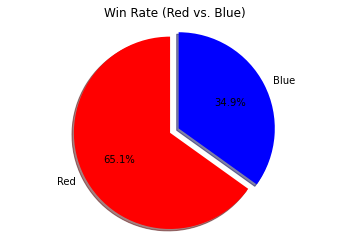

In [18]:
# Pie chart, Red vs. Blue win rate
pie_labels = ufc_df["Winner"].value_counts().index
pie_values = ufc_df["Winner"].value_counts().values
explode = (0, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()

ax1.pie(
    x=pie_values,
    labels=pie_labels,
    colors=["red", "blue"],
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axes.set_title("Win Rate (Red vs. Blue)")

plt.show()


### Age


In [19]:
# Generate descriptive statistics on Age columns (min, max, etc)
ufc_df[["R_Age", "B_Age"]].describe()


,R_Age,B_Age
count,6100.000000,6100.000000
mean,29.765738,29.397869
std,4.178314,4.026584
min,19.000000,18.000000
25%,27.000000,27.000000
50%,30.000000,29.000000
75%,32.000000,32.000000
max,47.000000,47.000000


<AxesSubplot:>

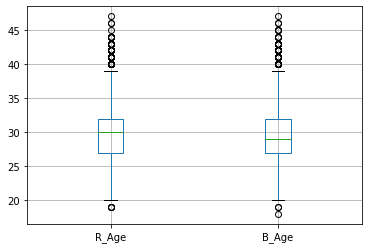

In [20]:
# Use Box & Whisker plot to visualize Age outliers
ufc_df.boxplot(column=["R_Age", "B_Age"])


### Height


In [21]:
# Generate descriptive statistics on Height columns (min, max, etc)
ufc_df[["R_Height", "B_Height"]].describe()


,R_Height,B_Height
count,6100.000000,6100.000000
mean,70.334918,70.323443
std,3.519760,3.462417
min,60.000000,60.000000
25%,68.000000,68.000000
50%,70.000000,70.000000
75%,73.000000,73.000000
max,83.000000,83.000000


<AxesSubplot:>

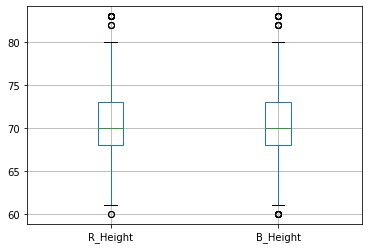

In [22]:
# Use Box & Whisker plot to visualize Height outliers
ufc_df.boxplot(column=["R_Height", "B_Height"])


### Weight


In [23]:
# Generate descriptive statistics on Weight columns (min, max, etc)
ufc_df[["R_Weight", "B_Weight"]].describe()


,R_Weight,B_Weight
count,6100.000000,6100.000000
mean,168.194098,167.780328
std,34.752299,34.561815
min,115.000000,115.000000
25%,145.000000,145.000000
50%,170.000000,168.000000
75%,185.000000,185.000000
max,265.000000,265.000000


<AxesSubplot:>

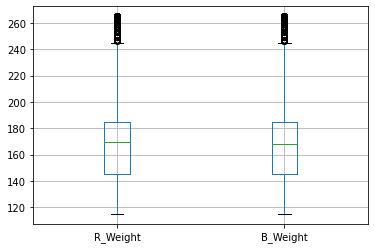

In [24]:
# Use Box & Whisker plot to visualize Weight outliers
ufc_df.boxplot(column=["R_Weight", "B_Weight"])


## Feature Engineering


### Feature Creation


#### Age Bucket


In [25]:
# Create four equal-sized buckets for the Age columns based on sample quantiles

ufc_df["R_Age_Bucket"] = pd.qcut(
    x=ufc_df["R_Age"], q=4, labels=None, retbins=False, precision=3
)


ufc_df["B_Age_Bucket"] = pd.qcut(
    x=ufc_df["B_Age"], q=4, labels=None, retbins=False, precision=3
)


# Drop age columns
# ufc_df = ufc_df.drop(columns=["R_Age", "B_Age"])


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


<AxesSubplot:title={'center':'Red Age Buckets'}>

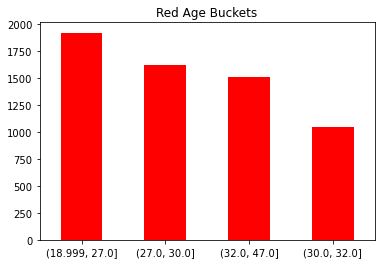

In [26]:
# Create a bar graph to visualize R_Age_Bucket
ufc_df["R_Age_Bucket"].value_counts().plot(
    kind="bar", color="red", rot=0, title="Red Age Buckets"
)


<AxesSubplot:title={'center':'Blue Age Buckets'}>

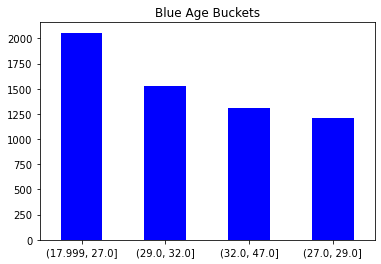

In [27]:
# Create a bar graph to visualize B_Age_Bucket
ufc_df["B_Age_Bucket"].value_counts().plot(
    kind="bar", color="blue", rot=0, title="Blue Age Buckets"
)


#### Height Bucket


In [28]:
# Create four equal-sized buckets for the Height columns based on sample quantiles

ufc_df["R_Height_Bucket"] = pd.qcut(
    x=ufc_df["R_Height"], q=4, labels=None, retbins=False, precision=3
)

ufc_df["B_Height_Bucket"] = pd.qcut(
    x=ufc_df["B_Height"], q=4, labels=None, retbins=False, precision=3
)

# Drop height columns
# ufc_df = ufc_df.drop(columns=["R_Height", "B_Height"])


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


<AxesSubplot:title={'center':'Red Height Buckets'}>

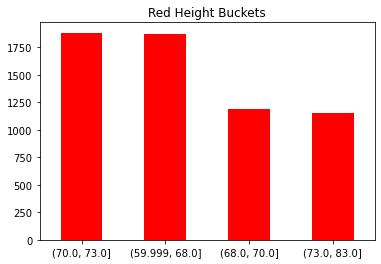

In [29]:
# Create a bar graph to visualize R_Height_Bucket
ufc_df["R_Height_Bucket"].value_counts().plot(
    kind="bar", color="red", rot=0, title="Red Height Buckets"
)


<AxesSubplot:title={'center':'Blue Height Buckets'}>

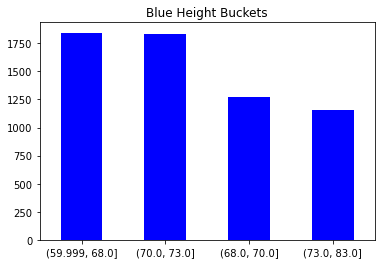

In [30]:
# Create a bar graph to visualize B_Height_Bucket
ufc_df["B_Height_Bucket"].value_counts().plot(
    kind="bar", color="blue", rot=0, title="Blue Height Buckets"
)


#### Weight Class


|   Weight Class    | Minimum Weight (lb) | Maximum Weight (lb) |
| :---------------: | :-----------------: | :-----------------: |
|    Heavyweight    |         205         |         265         |
| Light Heavyweight |         185         |         205         |
|   Middleweight    |         170         |         185         |
|   Welterweight    |         155         |         170         |
|    Lightweight    |         145         |         155         |
|   Featherweight   |         135         |         145         |
|   Bantamweight    |         125         |         135         |
|     Flyweight     |         115         |         125         |
|   Strawweight\*   |          0          |         115         |

- "The women’s UFC division is split into only 4 classes: strawweight, flyweight, bantamweight, and featherweight. The strawweight class is only used in the women’s division and men do not compete in it."


In [31]:
ufc_df[["R_Weight", "B_Weight"]].describe()


,R_Weight,B_Weight
count,6100.000000,6100.000000
mean,168.194098,167.780328
std,34.752299,34.561815
min,115.000000,115.000000
25%,145.000000,145.000000
50%,170.000000,168.000000
75%,185.000000,185.000000
max,265.000000,265.000000


In [32]:
# Keep rows that contain standardized weight class
ufc_df = ufc_df.loc[
    (ufc_df.Weight_Class == "Heavyweight")
    | (ufc_df.Weight_Class == "Light Heavyweight")
    | (ufc_df.Weight_Class == "Middleweight")
    | (ufc_df.Weight_Class == "Welterweight")
    | (ufc_df.Weight_Class == "Lightweight")
    | (ufc_df.Weight_Class == "Featherweight")
    | (ufc_df.Weight_Class == "Bantamweight")
    | (ufc_df.Weight_Class == "Flyweight")
    | (ufc_df.Weight_Class == "Strawweight")
    | (ufc_df.Weight_Class == "Women's Strawweight")
    | (ufc_df.Weight_Class == "Women's Flyweight")
    | (ufc_df.Weight_Class == "Women's Bantamweight")
    | (ufc_df.Weight_Class == "Women's Featherweight")
    # TODO: Should we exclude "Catch Weight", "Super Heavyweight", and "Open Weight"?
    # | (ufc_df.Weight_Class == "Catch Weight")
    # | (ufc_df.Weight_Class == "Super Heavyweight")
    # | (ufc_df.Weight_Class == "Open Weight")
    # TODO: Create `other` category for anything that does not fall in Weight_Class (?)
    # | (ufc_df.Winnner == "Other")
]


#### Gender


In [33]:
# Create Gender Fight Class Column

# TODO: There might be a *better* way of determining Gender, but this seems to works.
# ufc_df["Gender"] = np.where(
#     ufc_df["Weight_Class"].str.contains("Women's"), "Female", "Male"
# )

ufc_df["Gender"] = np.where(
    ufc_df["Weight_Class"].str.contains("Women's"), 0, 1
)  # Gender (sex) is 0 if female and 1 if male.


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [34]:
# display(
#     ufc_df.loc[
#         (ufc_df.Weight_Class == "Women's Strawweight")
#         | (ufc_df.Weight_Class == "Women's Flyweight")
#         | (ufc_df.Weight_Class == "Women's Bantamweight")
#         | (ufc_df.Weight_Class == "Women's Featherweight")
#     ].shape[0]
# )

ufc_df["Gender"].value_counts()


1    5212
0     507
Name: Gender, dtype: int64

#### Body Mass Index (BMI)


[Calculating BMI Using the English System](https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_2.html)

Formula:

> **weight** (lb) / [**height** (in)]<sup>2</sup> \* **703**


> "The normal BMI scores may not be accurate if you're very muscular because muscle can add extra kilos, resulting in a high BMI when you're not an unhealthy weight." ([National Health Service](https://www.nhs.uk/conditions/obesity/diagnosis/))


In [35]:
# Divide weight by height twice, multiply by 703, and round to one decimal place

# Calculate Red fighter BMI
ufc_df["R_BMI"] = round(ufc_df["R_Weight"] / ufc_df["R_Height"] ** 2 * 703, 1)

# Calculate Blue fighter BMI
ufc_df["B_BMI"] = round(ufc_df["B_Weight"] / ufc_df["B_Height"] ** 2 * 703, 1)


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


#### Proposed new BMI


[Proposed formula](https://web.archive.org/web/20220321050055/https://people.maths.ox.ac.uk/trefethen/bmi.html) by Nick Trefethen, Professor of numerical analysis at University of Oxford.

New formula:

> **5734** \* **weight** (lb) / [**height** (in)]<sup>2.5</sup>


In [36]:
# Calculate BMI with the new proposed formula.

# Calculate Red fighter BMI under proposed BMI
ufc_df["R_BMI_proposed"] = round(
    5734 * ufc_df["R_Weight"] / ufc_df["R_Height"] ** 2.5, 1
)

# Calculate Blue fighter BMI under proposed BMI
ufc_df["B_BMI_proposed"] = round(
    5734 * ufc_df["B_Weight"] / ufc_df["B_Height"] ** 2.5, 1
)


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


#### Estimation of Body Fat


Adult Body Fat Percentage

Formula:

> Body fat % = (1.39 \* BMI) + (0.16 \* Age) - (10.34 \* Gender) - 9)

- Where gender (sex) is 0 if female and 1 if male to account for the lower body fat percentage of men (International Journal of Obesity and Related Metabolic Disorders in 2002)


In [37]:
# Estimate Red Fighter Body Fat Percentage
ufc_df["R_Body_Fat_Percentage"] = (1.39 * ufc_df["R_BMI"]) + (0.16 * ufc_df["R_Age"] - (10.34 * ufc_df["Gender"]) - 9)

# Estimate Blue Fighter Body Fat Percentage
ufc_df["B_Body_Fat_Percentage"] = (1.39 * ufc_df["R_BMI"]) + (0.16 * ufc_df["R_Age"] - (10.34 * ufc_df["Gender"]) - 9)


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


#### Lean Body Mass


"For calculating lean body mass, body fat percentage was subtracted from 100 to get the lean mass percentage and lean mass percentage was divided by 100 to calculate the decimal for lean mass percentage, and then lean mass decimal was multiplied with total body weight." [(Prakash KO, Choudhary R, Singh G. Lean body mass, body fat percentage, and handgrip strength as predictors of bone mineral density in postmenopausal women. J Mid-life Health 2021;12:299-303)](https://www.jmidlifehealth.org/text.asp?2021/12/4/299/336149)

Formula(s):

> Lean Mass Percentage = 100 - Body Fat Percentage

> Lean Mass Decimal = Lean Mass Percentage / 100

> Lean Body Mass = Lean Mass Decimal \* Total Body Weight

> Lean Body Mass = ((100 - Body Fat Percentage) / 100) \* Total Body Weight


In [38]:
# Estimate Red Fighter Lean Body Mass
ufc_df["R_Lean_Body_Mass"] = ((100 - ufc_df["R_Body_Fat_Percentage"]) / 100) * ufc_df["R_Weight"]

# Estimate Blue Fighter Lean Body Mass
ufc_df["B_Lean_Body_Mass"] = ((100 - ufc_df["B_Body_Fat_Percentage"]) / 100) * ufc_df["B_Weight"]


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


### Set Categories


In [39]:
# Convert `winby` column into a category dtype
ufc_df["Win_By"] = ufc_df["Win_By"].astype("category")

# Convert stances column into a category dtype
ufc_df["R_Stance"] = ufc_df["R_Stance"].astype("category")
ufc_df["B_Stance"] = ufc_df["B_Stance"].astype("category")

# Convert Weight_Class column into a category dtype
ufc_df["Weight_Class"] = ufc_df["Weight_Class"].astype("category")

# Convert Gender column into a category dtype
ufc_df["Gender"] = ufc_df["Gender"].astype("category")
ufc_df["Gender"] = ufc_df["Gender"].cat.rename_categories({0: "Female", 1: "Male"})


### View Features


In [40]:
# View category dtypes
ufc_df.select_dtypes(include=["category"]).columns.tolist()


['Weight_Class',
 'Win_By',
 'B_Stance',
 'R_Stance',
 'R_Age_Bucket',
 'B_Age_Bucket',
 'R_Height_Bucket',
 'B_Height_Bucket',
 'Gender']

In [41]:
# View numerical values
ufc_df.select_dtypes(include=["number"]).columns.tolist()


['Max_Rounds',
 'Ending_Round',
 'B_Age',
 'B_Height',
 'B_Weight',
 'B_Wins',
 'B_Losses',
 'B_Career_Significant_Strikes_Landed_PM',
 'B_Career_Striking_Accuracy',
 'B_Career_Significant_Strike_Defence',
 'B_Career_Takedown_Average',
 'B_Career_Takedown_Accuracy',
 'B_Career_Takedown_Defence',
 'B_Career_Submission_Average',
 'B_Knockdowns',
 'B_Significant_Strikes_Landed',
 'B_Significant_Strikes_Attempted',
 'B_Significant_Strikes_Distance_Landed',
 'B_Significant_Strikes_Distance_Attempted',
 'B_Significant_Strikes_Clinch_Landed',
 'B_Significant_Strikes_Clinch_Attempted',
 'B_Significant_Strikes_Ground_Landed',
 'B_Significant_Strikes_Ground_Attempted',
 'B_Head_Significant_Strikes_Attempted',
 'B_Head_Significant_Strikes_Landed',
 'B_Body_Significant_Strikes_Attempted',
 'B_Body_Significant_Strikes_Landed',
 'B_Leg_Significant_Strikes_Attempted',
 'B_Leg_Significant_Strikes_Landed',
 'B_Total_Strikes_Attempted',
 'B_Total_Strikes_Landed',
 'B_Takedowns_Attempted',
 'B_Takedowns_

In [42]:
# TODO: Evaluate why some of these columns are inferred as strings
display(ufc_df.select_dtypes(include=["string"]).columns.tolist())

# TODO: Evaluate why some of these columns are inferred as object
display(ufc_df.select_dtypes(include=["object"]).columns.tolist())


['Winner',
 'B_Name',
 'B_Reach',
 'B_Draws',
 'B_No_Contest',
 'B_Significant_Strike_Perc',
 'B_Takedown_Perc',
 'B_Grappling_Control_Time',
 'B_Round_One_Significant_Strike_Perc',
 'B_Round_One_Takedown_Perc',
 'B_Round_One_Grappling_Control_Time',
 'B_Round_Two_Significant_Strike_Perc',
 'B_Round_Two_Takedown_Perc',
 'B_Round_Two_Grappling_Control_Time',
 'B_Round_Three_Significant_Strike_Perc',
 'B_Round_Three_Takedown_Perc',
 'B_Round_Three_Grappling_Control_Time',
 'B_Round_Four_Takedown_Perc',
 'B_Round_Four_Grappling_Control_Time',
 'B_Round_Five_Takedown_Perc',
 'B_Round_Five_Grappling_Control_Time',
 'R_Name',
 'R_Reach',
 'R_Draws',
 'R_No_Contest',
 'R_Significant_Strike_Perc',
 'R_Takedown_Perc',
 'R_Grappling_Control_Time',
 'R_Round_One_Significant_Strike_Perc',
 'R_Round_One_Takedown_Perc',
 'R_Round_One_Grappling_Control_Time',
 'R_Round_Two_Significant_Strike_Perc',
 'R_Round_Two_Takedown_Perc',
 'R_Round_Two_Grappling_Control_Time',
 'R_Round_Three_Significant_Strike

['B_Round_Four_Significant_Strike_Perc',
 'B_Round_Five_Significant_Strike_Perc',
 'R_Round_Five_Significant_Strike_Perc']

In [43]:
# Converting blue corner values to the correct dtype (Categorical or numeric)
ufc_df = ufc_df.astype({"B_Reach":"float","B_Name":"category", "B_Significant_Strike_Perc":"float", "B_Takedown_Perc":"float"
                        ,"B_Round_One_Significant_Strike_Perc":"float", "B_Round_One_Takedown_Perc":"float","B_Round_Two_Significant_Strike_Perc":"float",
                        "B_Round_Two_Takedown_Perc":"float","B_Round_Three_Significant_Strike_Perc":"float","B_Round_Three_Takedown_Perc":"float",
                        "B_Round_Four_Takedown_Perc":"float","B_Round_Five_Takedown_Perc":"float","B_Round_Four_Significant_Strike_Perc":"float",
                        "B_Round_Five_Significant_Strike_Perc":"float", "B_Draws":"float", "B_No_Contest":"float"})



In [44]:
# Converting red corner values to the correct dtype (Categorical or numeric)
ufc_df = ufc_df.astype({"R_Name":"category","R_Reach":"float", "R_Significant_Strike_Perc":"float", "R_Takedown_Perc":"float",
                        "R_Round_One_Significant_Strike_Perc":"float", "R_Round_One_Takedown_Perc":"float",
                        "R_Round_Two_Significant_Strike_Perc":"float","R_Round_Two_Takedown_Perc":"float", "R_Round_Three_Significant_Strike_Perc":"float",
                        "R_Round_Three_Takedown_Perc":"float","R_Round_Four_Takedown_Perc":"float", "R_Round_Five_Takedown_Perc":"float",
                        "R_Round_Five_Significant_Strike_Perc":"float","R_Draws":"float", "R_No_Contest":"float"})

### Select Features


In [45]:
numerical_cols = [
    "Max_Rounds",
    "Ending_Round",
    "B_Age",
    "R_Age",
    "B_Reach",
    "R_Reach",
    "B_Height",
    "R_Height",
    "B_Weight",
    "R_Weight",
    "R_BMI",
    "B_BMI",
    # "R_BMI_proposed",
    # "B_BMI_proposed",
    "R_Body_Fat_Percentage",
    "B_Body_Fat_Percentage",
    "R_Lean_Body_Mass",
    "B_Lean_Body_Mass",
    "B_Career_Significant_Strikes_Landed_PM",
    "R_Career_Significant_Strikes_Landed_PM",
    "R_Career_Striking_Accuracy",
    "R_Career_Significant_Strike_Defence",
    "R_Career_Takedown_Average",
    "R_Career_Takedown_Accuracy",
    "R_Career_Takedown_Defence",
    "R_Career_Submission_Average",
    "B_Career_Striking_Accuracy",
    "B_Career_Significant_Strike_Defence",
    "B_Career_Takedown_Average",
    "B_Career_Takedown_Accuracy",
    "B_Career_Takedown_Defence",
    "B_Career_Submission_Average",
]
categorical_cols = ["Win_By", "B_Stance", "R_Stance", "Weight_Class", "Gender"]

# numerical_cols = selector(dtype_include="number")
# categorical_cols = selector(dtype_include="category")

target = "Winner"


## Split Train-Test


In [46]:
X = ufc_df.drop(target, axis=1)
y = ufc_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## Machine Learning Model


### Logistic Regression Pipeline


In [47]:
# Imputation transformer to replace missing values using null values along each column.
# Standardize features by removing the mean and scaling to unit variance with `StandardScalar()`.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

# categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.712


### Display Diagram of Pipeline


In [48]:
set_config(display="diagram")
clf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Max_Rounds', 'Ending_Round',
                                                   'B_Age', 'R_Age', 'B_Reach',
                                                   'R_Reach', 'B_Height',
                                                   'R_Height', 'B_Weight',
                                                   'R_Weight', 'R_BMI', 'B_BMI',
                                                   'R_Body_Fat_Percentage',
                                                   'B_Body_Fat_Percen...
                                                   'B_Career_Striking_Accuracy',
                                                   'B_Career_Significant_Strike_Defence',
                                                   'B_Career_Takedown_Average',
                                                   'B_Career_Takedown_Accuracy',
                                                   'B_Career_Takedown_Defence',
                                                   'B_Career_Submission_Average']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Win_By', 'B_Stance',
                                                   'R_Stance', 'Weight_Class',
                                                   'Gender'])])),
                ('classifier', LogisticRegression(max_iter=500))])

### Classification Report


In [49]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Blue       0.62      0.41      0.49       390
         Red       0.74      0.87      0.80       754

    accuracy                           0.71      1144
   macro avg       0.68      0.64      0.64      1144
weighted avg       0.70      0.71      0.69      1144



### Confusion Matrix


In [50]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()


AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

### Stacking

In [ ]:
## NOTE: this cell was run in google colab
## include colab code to import from csv

# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Conduct analysis only on subset of features
subset_features = numerical_cols + categorical_cols + [target]
ufc_subset_df = ufc_df[subset_features]

# Drop rows that contain null values
ufc_subset_df = ufc_subset_df.dropna(axis=0, how="any")

# Encode categorical features with `get_dummies`
ufc_subset_df = pd.get_dummies(ufc_subset_df, columns=categorical_cols)

# Reset index
ufc_subset_df = ufc_subset_df.reset_index(drop=True)

# scale features
scaler = StandardScaler()
X = ufc_subset_df.drop("Winner", axis=1)
X_scaled = scaler.fit_transform(X)

# encode target with LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(ufc_subset_df["Winner"])

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('etc', ExtraTreesClassifier()))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('ada', AdaBoostClassifier()))
    level0.append(('rfc', RandomForestClassifier()))
    
    # define meta learner model
    level1 = LogisticRegression()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['etc'] = ExtraTreesClassifier()
    models['xgb'] = XGBClassifier()
    models['ada'] = AdaBoostClassifier()
    models['rfc'] = RandomForestClassifier()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X_scaled, y_encoded):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_scaled, y_encoded, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X_scaled, y_encoded)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### AutoML hyperopt-sklearn

In [51]:
#from sklearn.preprocessing import LabelEncoder
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe
from sklearn.preprocessing import LabelEncoder

# Conduct analysis only on subset of features
subset_features = numerical_cols + categorical_cols + [target]
ufc_subset_df = ufc_df[subset_features]

# Drop rows that contain null values
ufc_subset_df = ufc_subset_df.dropna(axis=0, how="any")

# Encode categorical features with `get_dummies`
ufc_subset_df = pd.get_dummies(ufc_subset_df, columns=categorical_cols)

# Reset index
ufc_subset_df = ufc_subset_df.reset_index(drop=True)

# scale features
scaler = StandardScaler()
X = ufc_subset_df.drop("Winner", axis=1)
X_scaled = scaler.fit_transform(X)

# encode target with LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(ufc_subset_df["Winner"])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=1)


# Configure HyperoptEstimator instance
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), 
                          algo=tpe.suggest, max_evals=50, trial_timeout=30)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.best_model())

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
 80%|█████████████████████████████▌       | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 89%|████████████████████████████████▉    | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 91%|███████████████████████████████▊   | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 95%|█████████████████████████████████▎ | 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:47:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 96%|█████████████████████████████████▌ | 23/24 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 96%|█████████████████████████████████▋ | 25/26 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|█████████████████████████████████▉ | 31/32 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|██████████████████████████████████ | 35/36 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 97%|██████████████████████████████████ | 38/39 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 98%|██████████████████████████████████▏| 45/46 [00:00<?, ?trial/s, best loss=?]

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:51:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|█████████| 50/50 [00:07<00:00,  7.58s/trial, best loss: 0.2724968314321926]
[15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6697061803444783
{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6104163160370274, colsample_bynode=1,
              colsample_bytree=0.9716123360510629, enable_categorical=False,
              gamma=0.000390839817446464, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.005660946556439732,
              max_delta_step=0, max_depth=3, min_child_weight=89, missing=nan,
              monotone_constraints='()', n_estimators=4000, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0.0012544379920988904, reg_lambda=3.4611966233441622,
              scale_pos_weight=1, seed=3, subsample=0.7200885323064201,
              tree_method='exact', validate_parameters=1, verbosity=None), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


#### XGBClassifier Pipeline

In [54]:
from xgboost import XGBClassifier
from numpy import nan

numerical_cols = selector(dtype_include="number")
categorical_cols = selector(dtype_include="category")

# Imputation transformer to replace missing values using null values along each column.
# Standardize features by removing the mean and scaling to unit variance with `StandardScalar()`.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

# categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6104163160370274, colsample_bynode=1,
              colsample_bytree=0.9716123360510629, enable_categorical=False,
              gamma=0.000390839817446464, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.005660946556439732,
              max_delta_step=0, max_depth=3, min_child_weight=89, missing=nan,
              monotone_constraints='()', n_estimators=4000, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0.0012544379920988904, reg_lambda=3.4611966233441622,
              scale_pos_weight=1, seed=3, subsample=0.7200885323064201,
              tree_method='exact', validate_parameters=1, verbosity=None)),
    ]
)

X = ufc_df.drop("Winner", axis=1)
y = ufc_df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

/Users/maximillianvincent/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model score: 0.883


### Display Diagram of Pipeline

In [55]:
set_config(display="diagram")
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f989a8c7c90>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.c...
                               learning_rate=0.005660946556439732,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=89, missing=nan,
                               monotone_constraints='()', n_estimators=4000,
                               n_jobs=1, num_parallel_tree=1, predictor='auto',
                               random_state=3, reg_alpha=0.0012544379920988904,
                               reg_lambda=3.4611966233441622,
                               scale_pos_weight=1, seed=3,
                               subsample=0.7200885323064201,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

### Classification Report

In [56]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Blue       0.87      0.77      0.82       390
         Red       0.89      0.94      0.91       754

    accuracy                           0.88      1144
   macro avg       0.88      0.86      0.87      1144
weighted avg       0.88      0.88      0.88      1144



### Confusion Matrix

In [57]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()


AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

### Model Persistence


In [ ]:
# from joblib import dump, load

# dump(clf, "clf.joblib")

# !!! WARNING: DO NOT LOAD RANDOM OBJECTS !!!
# clf = load("clf.joblib")

# # Prediction based on saved pipeline.
# selection = X.iloc[[5]]
# clf.predict(selection)


## Export Dataset


In [ ]:
# Export dataset to CSV
ufc_df.to_csv("Resources/new_data.csv", index=False)
